In [1]:
# import required library
if (!require(dummies)) {
    install.packages("dummies")
}
if (!require(DAAG)) {
    install.packages("DAAG")
}
if (!require(xgboost)) {
    install.packages("xgboost")
}
if (!require(randomForest)) {
    install.packages("randomForest")
}
if (!require(gbm)) {
    install.packages("gbm")
}
library(xgboost)
library(randomForest)
library(gbm)
library(dummies)  # dummy variable
library(moments)  # skewness
library(corrplot)  # corrplot
library(DAAG)  # cross-validation
library(glmnet)    # ridge and lasso

Loading required package: dummies
dummies-1.5.6 provided by Decision Patterns

Loading required package: DAAG
Loading required package: lattice
Loading required package: xgboost
Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: gbm
Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:DAAG’:

    lung

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



# Data Processing

In [2]:
# load the data set
train = read.csv('./train.csv')
test = read.csv('./test.csv')

# drop column of "LotFrontage", "Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"
drop.names = c("LotFrontage", "Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature")
train = train[ , !(names(train) %in% drop.names)]
test = test[ , !(names(test) %in% drop.names)]

# find all categorical and numerical variables
data.type = sapply(train[ , -c(1, ncol(train))], class)
categorical.var = names(train)[which(c(NA, data.type, NA) == 'factor')]
numerical.var = names(train)[which(c(NA, data.type, NA) == 'integer')]

# create new feature named "NA" for categorical variables
for (i in categorical.var) {
    train[, i] = addNA(train[, i])
    test[, i] = addNA(test[, i])
}

# # create new feature using the median value for numerical variables
# tempVar = c('MasVnrArea', 'GarageYrBlt')
# for (j in tempVar){
#     na.id = is.na(train[, j])  # binary indicator: NA (1) or not (0)
#     tempMedian = median(train[, j], na.rm = TRUE)  # find the median
#     train[which(na.id), j] = tempMedian
# }

# create new feature using the median value for numerical variables
for (i in numerical.var) {
    na.id = is.na(train[, i])
    if (!any(na.id)) {
        next
    }
    train[which(na.id), i] = median(train[, i], na.rm=TRUE)
}

# create new feature using the median value for numerical variables
for (i in numerical.var) {
    na.id = is.na(test[, i])
    if (!any(na.id)) {
        next
    }
    test[which(na.id), i] = median(train[, i], na.rm=TRUE)
}

# combine into one data frame
data = rbind(train[, -ncol(train)], test)

# transform numerical feature whose skewness is larger than 0.75
skewed.features = sapply(data[, numerical.var], skewness)
skewed.features = numerical.var[which(skewed.features > 0.75)]
for (i in skewed.features) {
    data[, i] = log(data[, i] + 1)
}

# find new categorical variable to create dummy variables
dummy.var = data.frame(dummy.data.frame(data[, categorical.var], sep='.'))
data = cbind(data, dummy.var)

# drop original categorical variables
data = data[ , !(names(data) %in% categorical.var)]

data.train = data[1:nrow(train), ]
data.test = data[(nrow(train) + 1):nrow(data), ]

data.train['SalePrice'] = train$SalePrice

# transform the response variable into log scale
data.train$SalePrice = log(data.train$SalePrice + 1)

# Simple Linear Regression

### With only numerical variables (high correlation only)

Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”

Warning message in cv.lm(data.train[, c(names(highCor), "SalePrice")], SalePrice ~ :
“

 As there is >1 explanatory variable, cross-validation
 predicted values for a fold are not a linear function
 of corresponding overall predicted values.  Lines that
 are shown for the different folds are approximate
”

[1] 86.07284

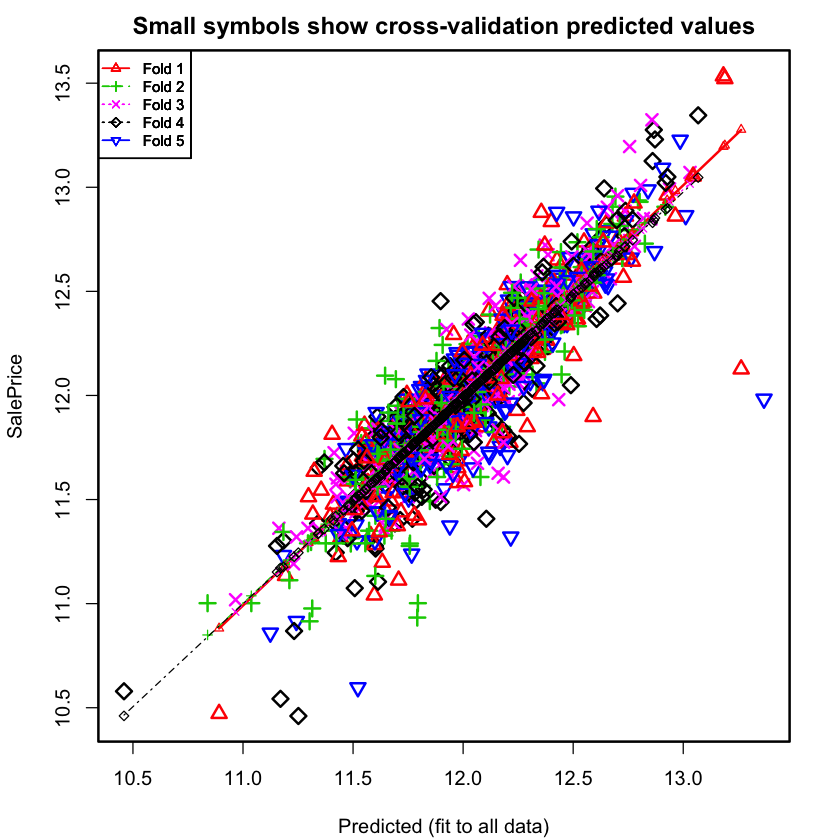

In [3]:
correlations = cor(data.train[, c(numerical.var, 'SalePrice')])  # correlation matrix

# for those relatively large correlations (> 0.3)
row_indic = apply(correlations, 1, function(x) sum(abs(x) > 0.3) > 1)
correlations = correlations[row_indic, row_indic]
    
# record those with very large correlation (> 0.6)
highCor = which(abs(correlations[, ncol(correlations)]) > 0.6)
highCor = highCor[-length(highCor)]

# cross-validation
model.cv = cv.lm(data.train[, c(names(highCor), 'SalePrice')], SalePrice ~ ., m=5, seed=29, printit=FALSE)
attr(model.cv, "ms")

In [4]:
# build model and make predictions
model = lm(SalePrice ~ ., data = data.train[, c(names(highCor), 'SalePrice')])
predict.test.y = predict(model, newdata=data.test)
predict.test.y = exp(predict.test.y) - 1

# make submission file
submission = read.csv('./result/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './result/LS_num_high_cor.csv', row.names = FALSE, sep = ',')

### With only numerical variables

Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”

Warning message in cv.lm(data.train[, c(numerical.var, "SalePrice")], SalePrice ~ :
“

 As there is >1 explanatory variable, cross-validation
 predicted values for a fold are not a linear function
 of corresponding overall predicted values.  Lines that
 are shown for the different folds are approximate
”

[1] 259.3596

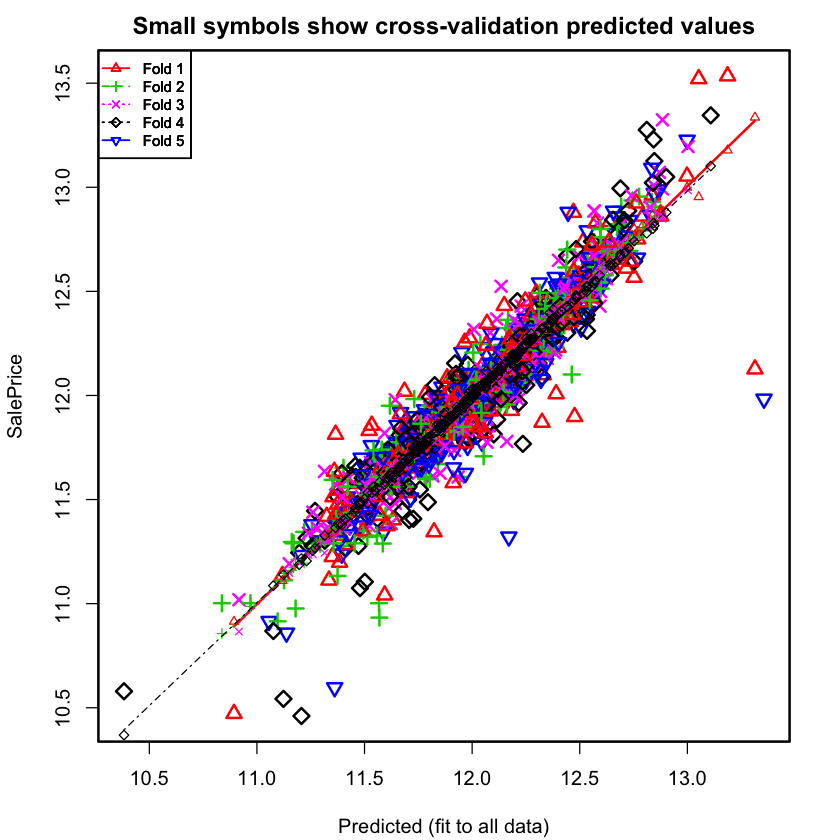

In [5]:
# cross-validation
model.cv = cv.lm(data.train[, c(numerical.var, 'SalePrice')], SalePrice ~ ., m=5, seed=29, printit=FALSE)
attr(model.cv, "ms")

In [6]:
# build model and make predictions
model = lm(SalePrice ~ ., data = data.train[, c(numerical.var, 'SalePrice')])
predict.test.y = predict(model, newdata=data.test)
predict.test.y = exp(predict.test.y) - 1

# make submission file
submission = read.csv('./result/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './result/LS_num_all.csv', row.names = FALSE, sep = ',')

### With all variables

Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”

Warning message in cv.lm(data.train, SalePrice ~ ., m = 5, seed = 29, printit = FALSE):
“

 As there is >1 explanatory variable, cross-validation
 predicted values for a fold are not a linear function
 of corresponding overall predicted values.  Lines that
 are shown for the different folds are approximate
”

[1] 54.90106

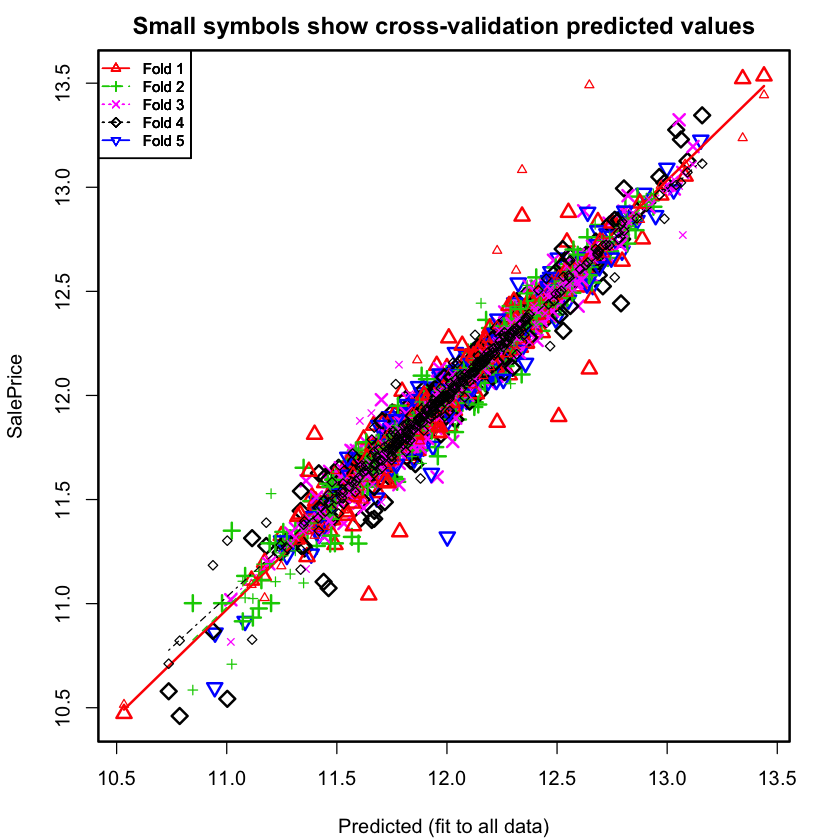

In [7]:
# cross-validation
model.cv = cv.lm(data.train, SalePrice ~ ., m=5, seed=29, printit=FALSE)
attr(model.cv, "ms")

In [8]:
# build model and make predictions
model = lm(SalePrice ~ ., data = data.train)
predict.test.y = predict(model, newdata=data.test)
predict.test.y = exp(predict.test.y) - 1

# make submission file
submission = read.csv('./result/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './result/LS_all.csv', row.names = FALSE, sep = ',')

Warning message in predict.lm(model, newdata = data.test):
“prediction from a rank-deficient fit may be misleading”

# Ridge Regression Model

In [9]:
# build the model
cv.ridge = cv.glmnet(as.matrix(data.train[, -c(1, ncol(data.train))]), 
                     data.train[, 'SalePrice'], nfolds=10)
lambda_ridge = cv.ridge$lambda.min   # this is the optimal lambda with minimal shrinkage

#lambda_ridge, alpha = 0 is ridge regression
ridge.fit = glmnet(as.matrix(data.train[, -c(1, ncol(data.train))]), 
                   data.train[, 'SalePrice'], alpha=0, lambda=lambda_ridge)
predict.test.y = predict(ridge.fit, s=lambda_ridge, newx=as.matrix(data.test[, -1]))
predict.test.y = exp(predict.test.y) - 1

#cv.ridge$cvm
submission = read.csv('./result/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './result/ridge.csv', row.names = FALSE, sep = ',')

# Lasso Regression Model

In [10]:
# lasso regression
cv.lasso = cv.glmnet(as.matrix(data.train[, -c(1, ncol(data.train))]), 
                     data.train[, 'SalePrice'], nfolds=10)
lambda_lasso = cv.lasso$lambda.min   # this is the optimal lambda with minimal shrinkage

#lambda_lasso, alpha = 1 is lasso regression
lasso.fit = glmnet(as.matrix(data.train[,-c(1, ncol(data.train))]), 
                   data.train[, 'SalePrice'], alpha=1, lambda=lambda_lasso)
predict.test.y = predict(lasso.fit, s=lambda_lasso, newx=as.matrix(data.test[, -1]))
predict.test.y = exp(predict.test.y) - 1

#cv.lasso$cvm
submission = read.csv('./result/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './result/lasso.csv', row.names = FALSE, sep = ',')

# Xgboost Model

In [11]:
# get x and y variables
train.y = as.numeric(data.train$SalePrice)
train.x = data.train[, c(-1, -289)]
train.x = apply(train.x, 2, as.numeric)

test.x = data.test[, -1]
test.x = apply(test.x, 2, as.numeric)

In [12]:
# cross-validation
set.seed(100)
cv.dum = xgb.cv(data=train.x, label=train.y, nfold=5, max.depth=2, 
                eta=1, nround=100, objective='reg:linear')

[1]	train-rmse:0.399375+0.004733	test-rmse:0.399298+0.018786 
[2]	train-rmse:0.247774+0.004589	test-rmse:0.253076+0.017702 
[3]	train-rmse:0.212437+0.004851	test-rmse:0.227975+0.015115 
[4]	train-rmse:0.197967+0.004579	test-rmse:0.217213+0.014913 
[5]	train-rmse:0.186223+0.006324	test-rmse:0.210608+0.012450 
[6]	train-rmse:0.177458+0.006189	test-rmse:0.204019+0.013405 
[7]	train-rmse:0.168980+0.005644	test-rmse:0.195784+0.011861 
[8]	train-rmse:0.164291+0.005647	test-rmse:0.195603+0.015103 
[9]	train-rmse:0.159002+0.006508	test-rmse:0.190105+0.014031 
[10]	train-rmse:0.154362+0.006522	test-rmse:0.187882+0.012233 
[11]	train-rmse:0.149495+0.005457	test-rmse:0.183006+0.012613 
[12]	train-rmse:0.145663+0.005389	test-rmse:0.177795+0.014560 
[13]	train-rmse:0.141279+0.005666	test-rmse:0.174613+0.013064 
[14]	train-rmse:0.137961+0.005595	test-rmse:0.174183+0.013852 
[15]	train-rmse:0.134670+0.005494	test-rmse:0.172825+0.013279 
[16]	train-rmse:0.131425+0.005233	test-rmse:0.171623+0.015072 
[

In [13]:
# build model and make predictions
bst.dum = xgboost(data=train.x, label=train.y, max.depth=2, eta=1, 
                  nround=50, objective='reg:linear', verbose=FALSE)
predict.test.y = predict(bst.dum, test.x)
predict.test.y = exp(predict.test.y) - 1

# make submission file
submission = read.csv('./result/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './result/xgboost.csv', row.names = FALSE, sep = ',')

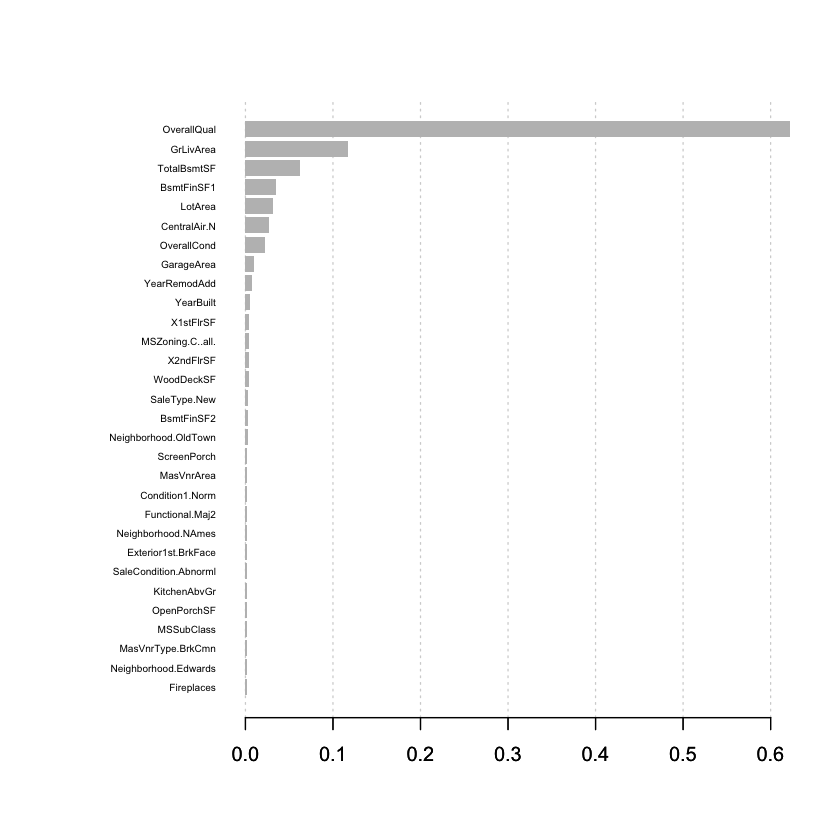

In [14]:
# plot the importance
importance_matrix = xgb.importance(names(data.train[, c(-1, -289)]), model=bst.dum)
xgb.plot.importance(importance_matrix[1:30])

# Random Forest Model

In [15]:
# build the model
model = randomForest(SalePrice ~ ., data=data.train, importance=T, ntree=500)
predict.train.y = predict(model, data.train)
train.mse = sum((predict.train.y - data.train$SalePrice) ^ 2) / length(predict.train.y)

predict.test.y = predict(model, data.test)
predict.test.y = exp(predict.test.y) - 1

# make submission file
submission = read.csv('./result/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './result/randomForest.csv', row.names = FALSE, sep = ',')

In [16]:
# # cross-validation
# model = rfcv(train.x, train.y, cv.fold=5)
# cv.mse = sum((data.train$SalePrice - model.cv$cvpred) ^ 2) / nrow(data.train)

# GBM Model

Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 42: MSZoning.NA has no variation.”Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 55: Utilities.NA has no variation.”Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 148: Exterior1st.NA has no variation.”Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 165: Exterior2nd.NA has no variation.”Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 238: KitchenQual.NA has no variation.”Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 246: Functional.NA has no variation.”Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 282: SaleType.NA has no variation.”

[1] 315

Using 315 trees...


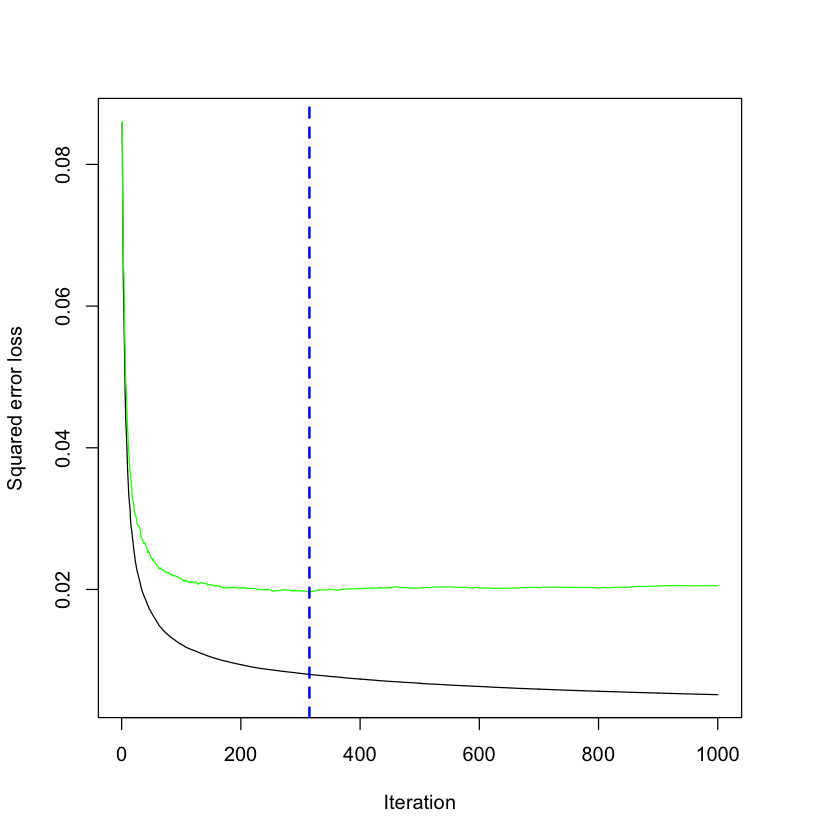

In [17]:
# build the model
gbm = gbm(SalePrice ~ ., data=data.train, distribution='gaussian', 
          n.trees=1000, shrinkage=1, bag.fraction=1, cv.folds=5)
gbm.perf(gbm, method='cv')

predict.test.y = predict(gbm, data.test, type='response')
predict.test.y = exp(predict.test.y) - 1

# make submission file
submission = read.csv('./result/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './result/GBM.csv', row.names = FALSE, sep = ',')